In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%cd ..

/scratch/km817/iREC


In [4]:
import torch
import torch.distributions as dist
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from rec.utils import kl_estimate_with_mc, plot_running_sum_2d, plot_2d_distribution, kl_estimate_with_mc, compute_variational_posterior
from tqdm.notebook import trange
#import seaborn as sns; sns.set(); sns.set_style('whitegrid')
import math
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [5]:
torch.set_default_tensor_type(torch.DoubleTensor)

In [6]:
from rec.beamsearch.Coders.Encoder_Variational import Encoder
from rec.beamsearch.distributions.CodingSampler import CodingSampler
from rec.beamsearch.distributions.VariationalPosterior import VariationalPosterior
from rec.beamsearch.samplers.GreedySampling import GreedySampler
from rec.OptimisingVars.VariationalOptimiser import VariationalOptimiser

# Problem 1

The KL between q and p is 18.074 nats.


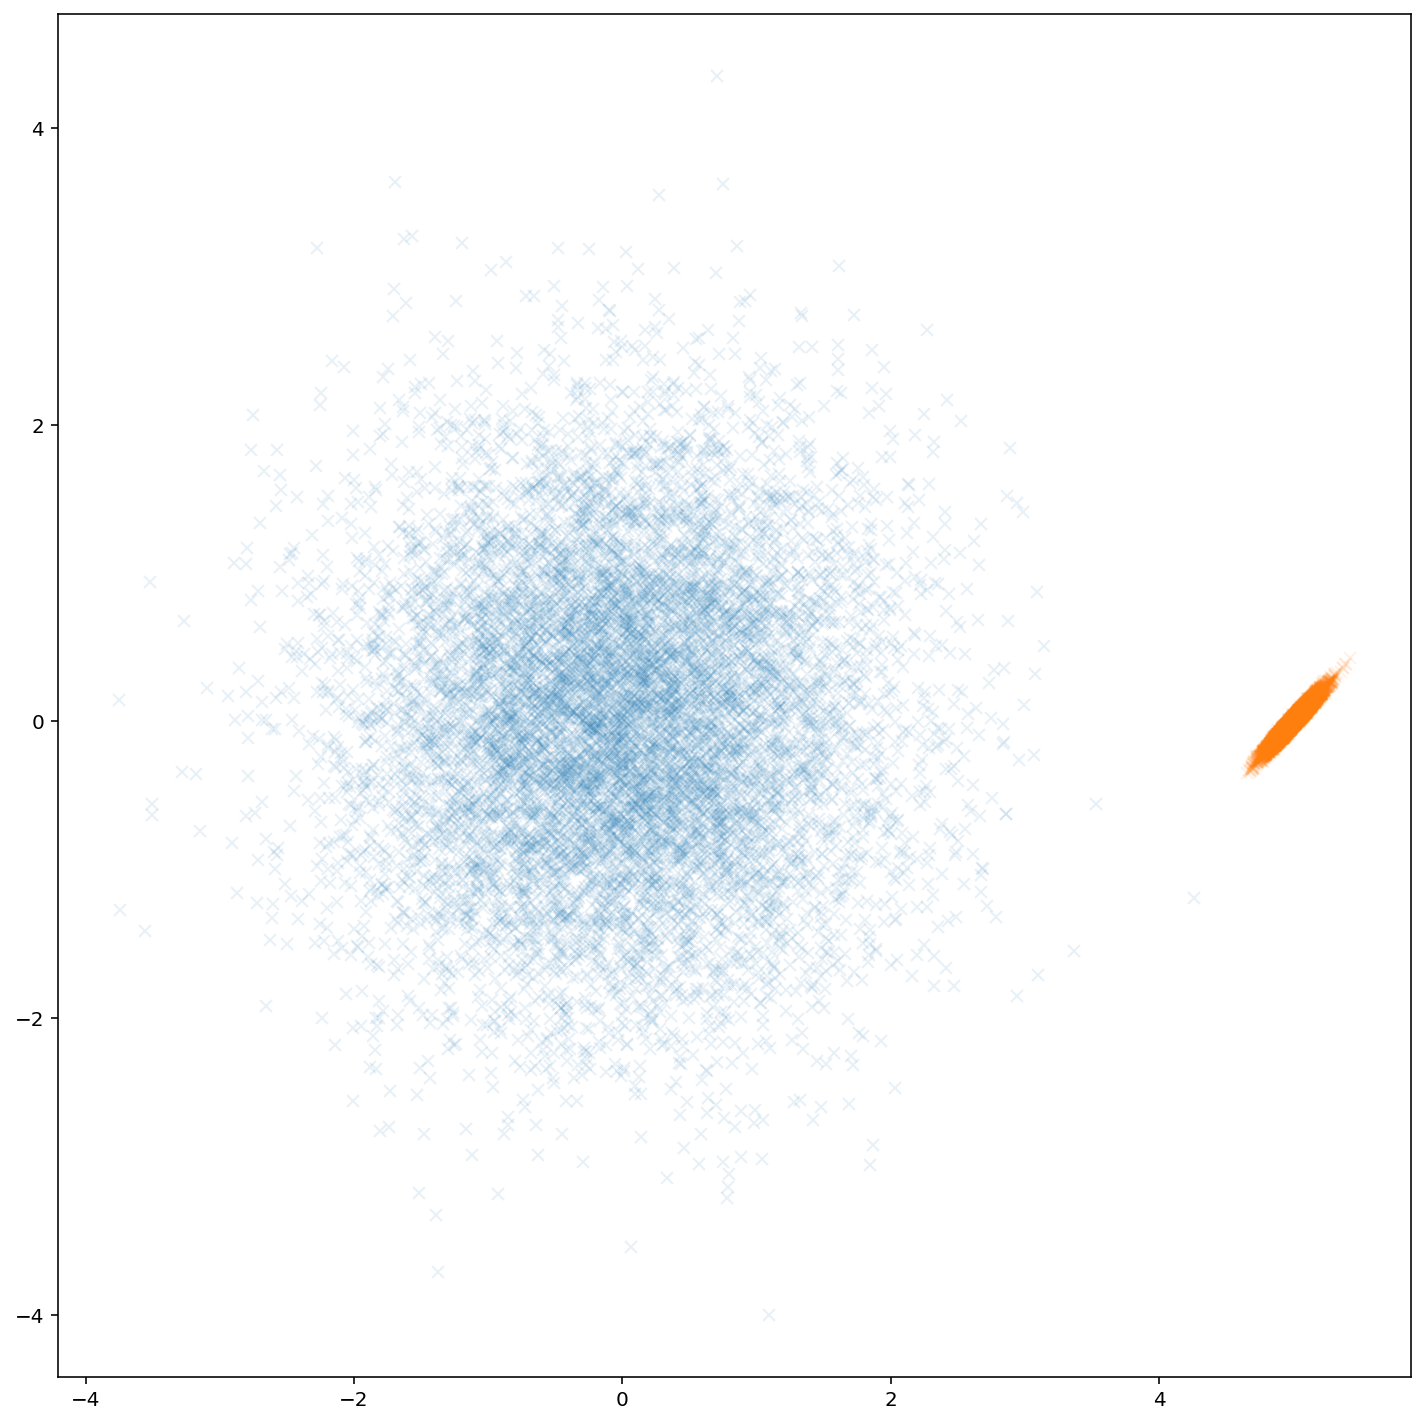

In [114]:
torch.manual_seed(100)

q_loc = [5., 0.]
q_covar = [[1, 0.999], [0.99, 1]]

p_loc = [0., 0.]
p_var = 1.

q = dist.MultivariateNormal(loc=torch.tensor(q_loc), covariance_matrix = 1e-2 * torch.tensor(q_covar))
p = dist.MultivariateNormal(loc=torch.tensor(p_loc), covariance_matrix = p_var * torch.eye(2))

z_sample = q.sample()

try:
    total_kl = dist.kl_divergence(q, p)
except:
    total_kl = kl_estimate_with_mc(q, p, num_samples=10000).mean()
print(f"The KL between q and p is {total_kl:.3f} nats.")

# ==============================
# PLOT DISTRIBUTIONS
# ==============================
p_samples = p.sample((10000,))
q_samples = q.sample((10000,))
f, ax = plt.subplots(1, figsize=(10,10))
ax.plot(p_samples[:,0], p_samples[:,1], 'x', alpha=0.1)
ax.plot(q_samples[:,0], q_samples[:,1], 'x', alpha=0.1)

f.tight_layout()


In [115]:
from rec.beamsearch.Coders.Encoder import Encoder
from rec.beamsearch.distributions.CodingSampler import CodingSampler
from rec.beamsearch.distributions.EmpiricalMixturePosterior import EmpiricalMixturePosterior
from rec.beamsearch.samplers.GreedySampling import GreedySampler

In [44]:
from rec.OptimisingVars.FinalJointOptimiser import FinalJointOptimiser
coding_sampler = CodingSampler
auxiliary_posterior = EmpiricalMixturePosterior
selection_sampler = GreedySampler
omega = 5
initial_seed = 0
beamwidth = 1
epsilon = 0.
alpha = 1./p_var
dummy_encoder = Encoder(q,
                         initial_seed,
                         coding_sampler,
                         selection_sampler,
                         auxiliary_posterior,
                         omega,
                        n_samples_from_target=10,
                         beamwidth=beamwidth,
                         epsilon=epsilon,
                         prior_var=1./alpha)

omega = 5
n_trajectories = 100000
n_auxiliaries = dummy_encoder.n_auxiliary
prior_var = 1./alpha
emp_opt = FinalJointOptimiser(z_sample, omega, n_auxiliaries, total_kl, n_trajectories, prior_var, lr=5e-2)
aux_vars = emp_opt.run_optimiser(epochs=1000)

The mean loss is 9.26822. The mean KL is: 5.89502: 100%|██████████| 1000/1000 [04:22<00:00,  3.81it/s]


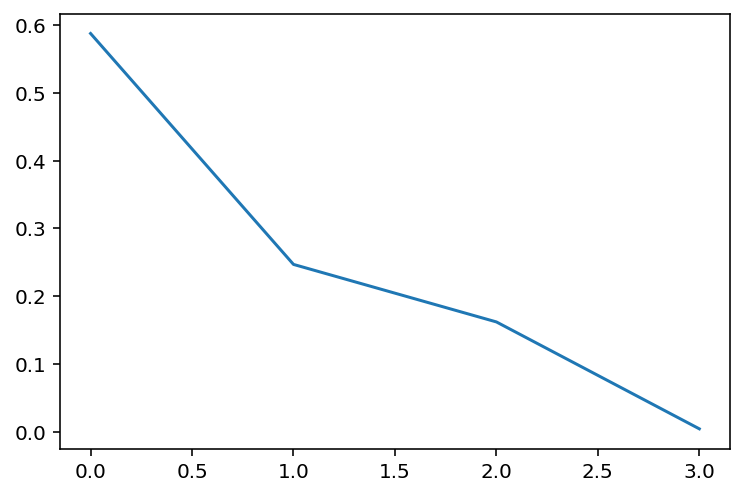

In [45]:
plt.plot(aux_vars)

In [116]:
omega = 5
initial_seed = 110
beamwidth = 1
epsilon = 0.

enc = Encoder(q,
             initial_seed,
             coding_sampler,
             selection_sampler,
             auxiliary_posterior,
             omega,
             n_samples_from_target=10,
             beamwidth=beamwidth,
             epsilon=epsilon,
             prior_var=1./alpha,
             total_kl=total_kl)

enc.auxiliary_posterior.coding_sampler.auxiliary_vars = aux_vars
z, idx =  enc.run_encoder()

In [117]:
emp_traj_optimised = enc.selected_samples[0]

In [118]:
omega = 5
beamwidth = 1
epsilon = 0.
initial_seed = 110

enc = Encoder(q,
             initial_seed,
             coding_sampler,
             selection_sampler,
             auxiliary_posterior,
             omega,
             n_samples_from_target=10,
             beamwidth=beamwidth,
             epsilon=epsilon,
             prior_var=1./alpha,
             total_kl=total_kl)

#enc.auxiliary_posterior.coding_sampler.auxiliary_vars = aux_vars
z, idx =  enc.run_encoder()

In [119]:
emp_traj_uniform = enc.selected_samples[0]

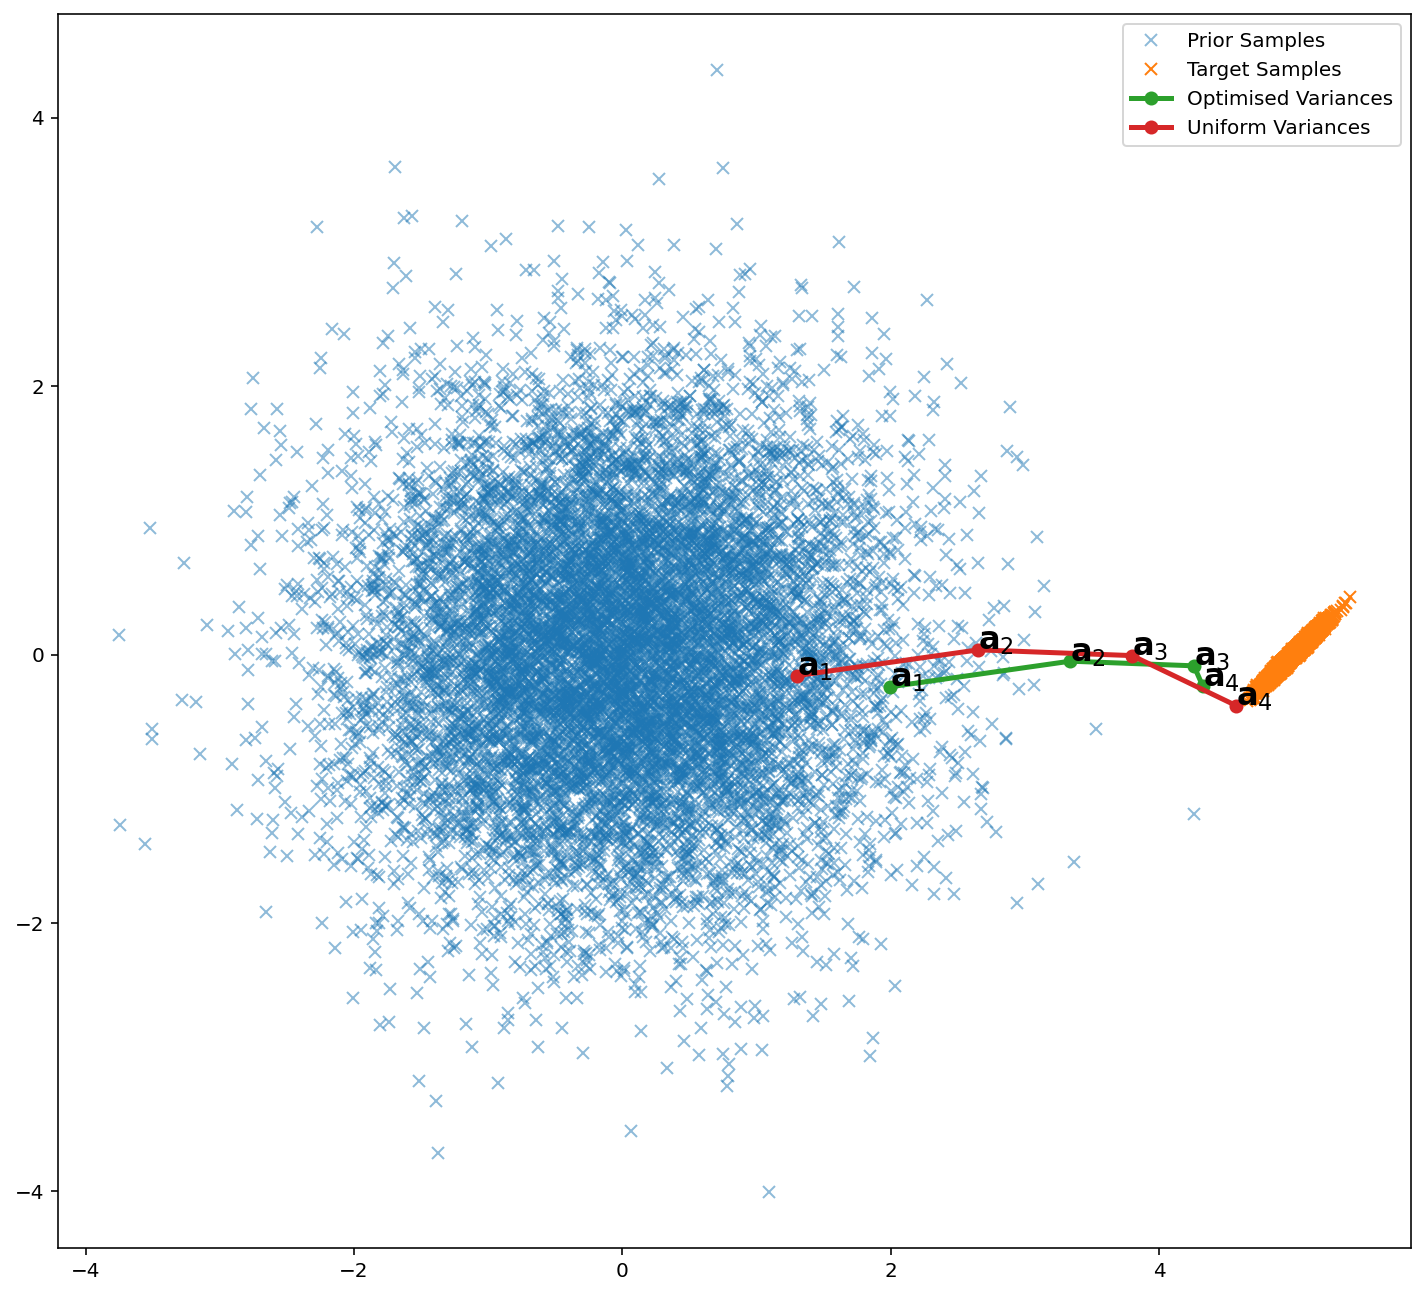

In [120]:
f, ax = plt.subplots(1, figsize=(10,10))
ax.plot(p_samples[:,0], p_samples[:,1], 'x', alpha=.5)
ax.plot(q_samples[:,0], q_samples[:,1], 'x', alpha=1.)
ax.set_aspect('equal', adjustable='box')
plot_running_sum_2d(emp_traj_optimised, plot_index_labels=True)
plot_running_sum_2d(emp_traj_uniform, plot_index_labels=True)
ax.legend(['Prior Samples', 'Target Samples', 'Optimised Variances', 'Uniform Variances'])
f.tight_layout()

In [131]:
omega = 5
initial_seed = 110
beamwidth = 5
epsilon = 0.3

enc = Encoder(q,
             initial_seed,
             coding_sampler,
             selection_sampler,
             auxiliary_posterior,
             omega,
             n_samples_from_target=10,
             beamwidth=beamwidth,
             epsilon=epsilon,
             prior_var=1./alpha,
             total_kl=total_kl)

enc.auxiliary_posterior.coding_sampler.auxiliary_vars = aux_vars
z, idx =  enc.run_encoder()

In [132]:
emp_traj_optimised = enc.selected_samples[0]

In [133]:
omega = 5
beamwidth = 5
epsilon = 0.3
initial_seed = 110

enc = Encoder(q,
             initial_seed,
             coding_sampler,
             selection_sampler,
             auxiliary_posterior,
             omega,
             n_samples_from_target=10,
             beamwidth=beamwidth,
             epsilon=epsilon,
             prior_var=1./alpha,
             total_kl=total_kl)

#enc.auxiliary_posterior.coding_sampler.auxiliary_vars = aux_vars
z, idx =  enc.run_encoder()

In [134]:
emp_traj_uniform = enc.selected_samples[0]

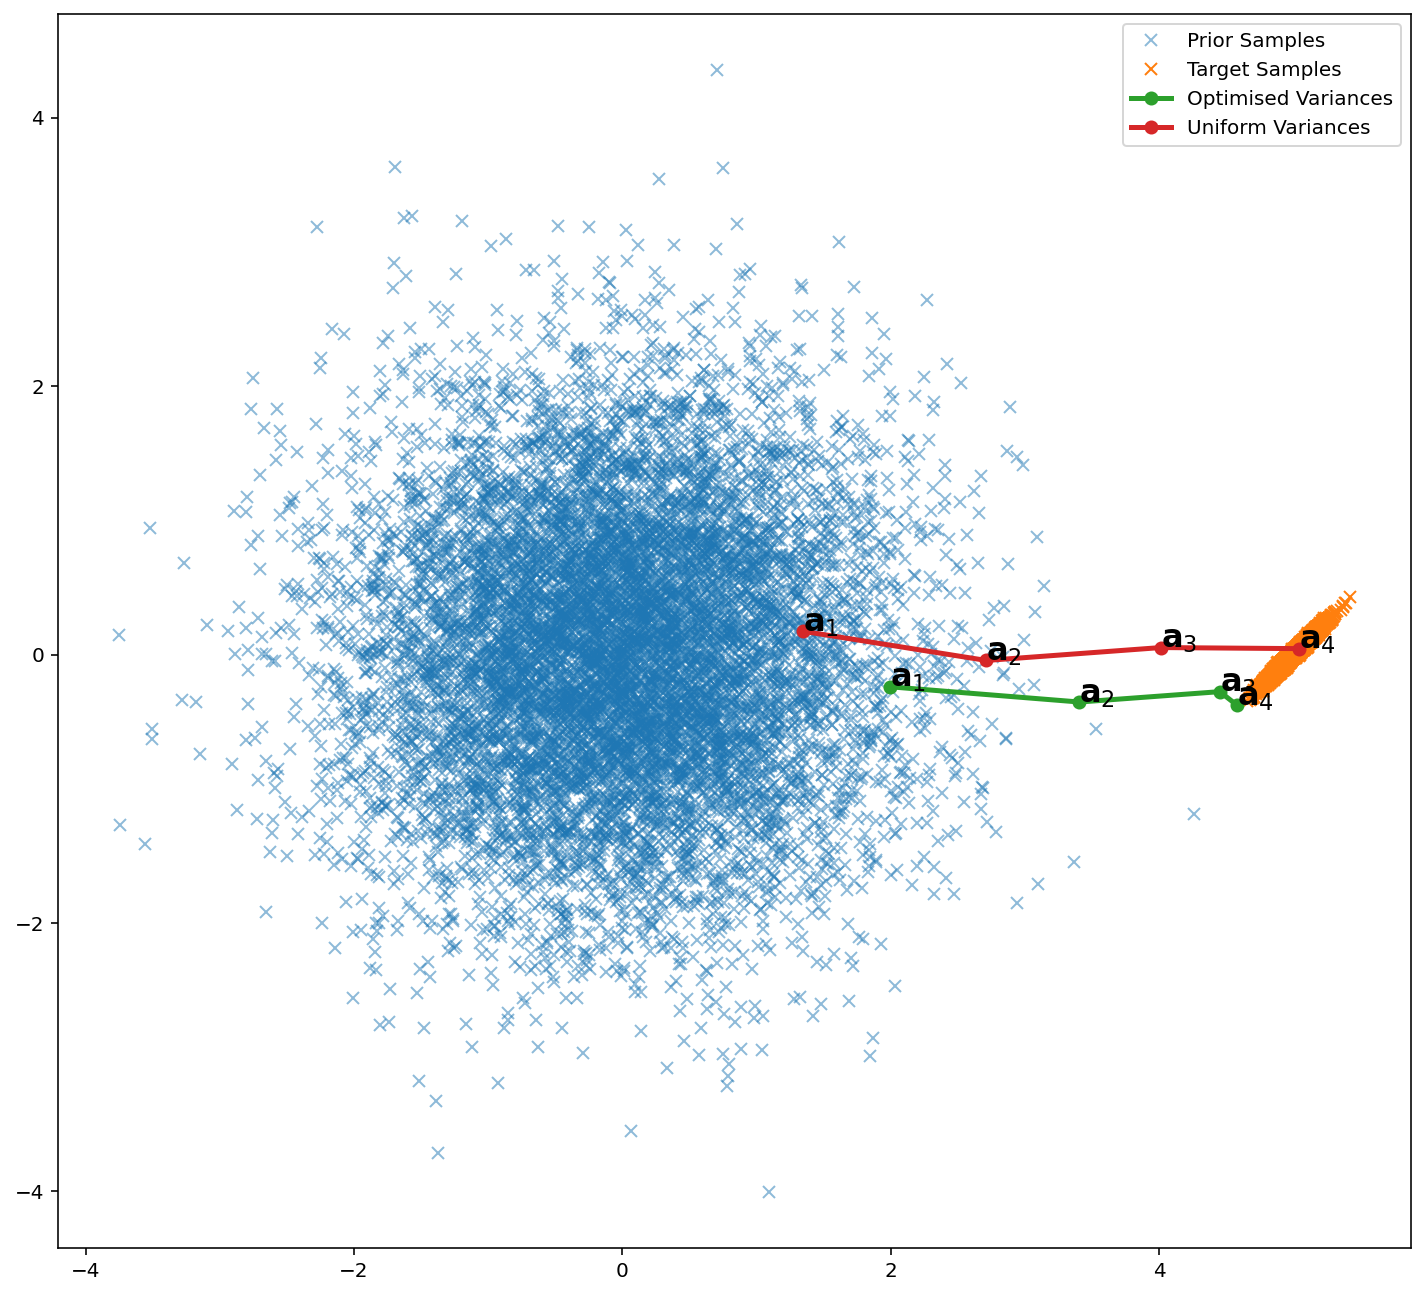

In [135]:
f, ax = plt.subplots(1, figsize=(10,10))
ax.plot(p_samples[:,0], p_samples[:,1], 'x', alpha=.5)
ax.plot(q_samples[:,0], q_samples[:,1], 'x', alpha=1.)
ax.set_aspect('equal', adjustable='box')
plot_running_sum_2d(emp_traj_optimised, plot_index_labels=True)
plot_running_sum_2d(emp_traj_uniform, plot_index_labels=True)
ax.legend(['Prior Samples', 'Target Samples', 'Optimised Variances', 'Uniform Variances'])
f.tight_layout()